In [1]:
shape_cat=""
vol=""

In [7]:
# Parameters
shape_cat = "mcal"
vol = "all"

from tqdm import tqdm

In [8]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import fitsio as fio
import numpy as np
import ast

import astropy.cosmology
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from IPython.display import display, Math

In [9]:
if vol=="vlim":
    cluster_table=Table(fits.open('/lsst/troxel/y1a1/y1a1_gold_1.0.3-d10-mof-001d_run_redmapper_v6.4.17-vlim_lgt20_desformat_catalog.fit')[1].data)
    member_table=Table(fits.open('/lsst/troxel/y1a1/y1a1_gold_1.0.3-d10-mof-001d_run_redmapper_v6.4.17-vlim_lgt20_desformat_catalog_members.fit')[1].data)
    random_table=Table(fits.open('/lsst/troxel/y1a1/y1a1_gold_1.0.3_wide+d10-mof-001d_run_redmapper_v6.4.17-2_randcat_z0.10-0.95_lgt020_vl50.fit')[1].data)
elif vol=="all":
    cluster_table=Table(fits.open('/lsst/troxel/y1a1/y1a1_gold_1.0.3-d10-mof-001d_run_redmapper_v6.4.17_lgt20_desformat_catalog.fit')[1].data)
    member_table=Table(fits.open('/lsst/troxel/y1a1/y1a1_gold_1.0.3-d10-mof-001d_run_redmapper_v6.4.17_lgt20_desformat_catalog_members.fit')[1].data)
    random_table=Table(fits.open('/lsst/troxel/y1a1/y1a1_gold_1.0.3_wide+d10-mof-001d_run_redmapper_v6.4.17-2_randcat_z0.10-0.95_lgt020_vl02.fit')[1].data)
else:
    raise TypeError("Wrong vol")
cluster_table.remove_columns(['P_C','C_LAMBDA','C_LAMBDA_ERR','Q_CEN']) #unknown columns

print(len(member_table))
print(len(cluster_table))
print(len(member_table['ID'])-len(np.unique(member_table['ID'])))

809723
16966
5621


In [10]:
from astropy.coordinates import SkyCoord  # High-level coordinates
import astropy.units as u
def get_theta_for_obj_raw(obj1,obj2):
    ra1,dec1=(obj1['RA'],obj1['DEC'])
    ra2,dec2=(obj2['RA'],obj2['DEC'])
    
    
    
    c1=SkyCoord(ra1*u.deg,dec1*u.deg)
    c2=SkyCoord(ra2*u.deg,dec2*u.deg)
    
    
    return(90-c1.position_angle(c2).degree)

In [11]:
def get_rel_theta_raw(member):
    cluster=cluster_table[cluster_table['MEM_MATCH_ID']==member['MEM_MATCH_ID']]
    center_id=cluster['ID_CENT'][0][0]
#     print(center_id)
    center=member_table[member_table['ID']==center_id]
    
#     print(center['RA'])
    theta=get_theta_for_obj_raw(center,member)
    return(theta)

In [12]:
test=np.empty(len(member_table))
for i in tqdm(range(len(member_table))):
    try:
        test[i]=get_rel_theta_raw(member_table[i])
    except ValueError as e:
        test[i]=get_rel_theta_raw(member_table[i])[0]

100%|██████████| 809723/809723 [2:09:58<00:00, 103.83it/s]  


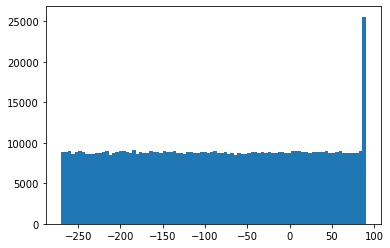

In [14]:
import matplotlib.pyplot as plt
plt.hist(test,bins=90)
plt.show()

In [146]:
if shape_cat=="mcal":
    mcal = fio.FITS('/lsst/troxel/y1a1/mcal-y1a1-combined-riz-unblind-v4-matched.fits',memmap=True,mode='r')[1]
    print ("Metacal loaded")
    shape_id=mcal['coadd_objects_id'][:] 
elif shape_cat=="im3":
        mcal = fio.FITS('/lsst/troxel/y1a1/y1a1-im3shape_v5_unblind_v2_matched_v4.fits',memmap=True,mode='r')[1]
        print ("Metacal loaded")
        shape_id=mcal['coadd_objects_id'][:] 
else:
    raise 

Metacal loaded


In [147]:
problem_list =['MODEL_MAG', 'MODEL_MAGERR', 'MAG_LAMBDA_ERR', 'PZBINS',
               'PZ', 'RA_CENT', 'DEC_CENT', 'ID_CENT', 'LAMBDA_CHISQ_CENT',
               'ZLAMBDA_CENT', 'P_BCG', 'P_CEN', 'P_FG', 'P_SAT']

In [148]:
member_id=member_table['ID']
member_mask=np.in1d(member_id,shape_id)
member_masked=member_table[member_mask]

In [150]:
test_0=get_rel_theta_raw(member_masked)
print(len(test_0))

NameError: name 'clusters_table' is not defined

In [ ]:
plt.hist(test_0,bins=90)

In [ ]:
band_col_list = []
pz_col_list = []
alt_col_list =[]
for problem in problem_list:
    if cluster_table[problem].shape[1]==4:
        band_col_list.append(problem)
    elif cluster_table[problem].shape[1]==5:
        alt_col_list.append(problem)
    elif cluster_table[problem].shape[1]==21:
        pz_col_list.append(problem)
    else:
        print ("error")

In [ ]:
band_list=['g','r','i','z','Y']
pz_index_list=['pz'+str(i+1) for i in range(21)]
alt_index_list=['Alt'+str(i+1) for i in range(5)]

In [ ]:
for j in range(4):
    for i,column in enumerate(band_col_list):
        cluster_table[str(('Band',band_list[j],column))]=cluster_table[column].data[:,j]
cluster_table.remove_columns(band_col_list)

In [ ]:
for i,column in enumerate(pz_col_list):
    for j in range(21):
        cluster_table[str(('PZ',pz_index_list[j],column))]=cluster_table[column].data[:,j]
cluster_table.remove_columns(pz_col_list)

In [ ]:
for i,column in enumerate(alt_col_list):
    for j in range(5):
        cluster_table[str(('Alt',alt_index_list[j],column))]=cluster_table[column].data[:,j]
cluster_table.remove_columns(alt_col_list)

In [ ]:
all_col_list=list(cluster_table.columns[0:54])
for i,column in enumerate(all_col_list):
    cluster_table[str(('All','All',column))]=cluster_table[column].data[:]
cluster_table.remove_columns(all_col_list)

In [ ]:
for j in range(4):
    for i,column in enumerate(band_col_list[0:2]):
        member_table['('+band_list[j]+','+column+')']=member_table[column].data[:,j]
member_table.remove_columns(band_col_list[0:2]) 

In [ ]:
clusters=cluster_table.to_pandas()
member=member_table.to_pandas()
random=random_table.to_pandas()
# center_table=None
# member_table=None

In [ ]:
member_cols = member.columns[0:22]
shape_columns=pd.MultiIndex.from_product([['All'],list(mcal.get_colnames())],names=['Band','Data'])

In [ ]:
center_bins=[m+str(n) for m,n in zip(['cen_']*5,np.arange(5)+1)]
center=pd.MultiIndex.from_product([['Center'],center_bins,member_cols])

In [ ]:
cluster_band_columns=pd.MultiIndex.from_product([['g','r','i','z'],
                                       ['MODEL_MAG','MODEL_MAGERR','MAG_LAMBDA_ERR']],
                                     names=['band','data'])

In [ ]:
# alt_bins=[m+str(n) for m,n in zip(['alt_']*5,np.arange(5)+1)]
# alt_columns=pd.MultiIndex.from_product([alt_bins,
#                                        alt_col_list.append(shape_names)],
#                                      names=['alt_index','data'])

In [ ]:
member_band_columns=pd.MultiIndex.from_product([['g','r','i','z'],
                                       ['MODEL_MAG','MODEL_MAGERR',]],
                                     names=['Band','Data'])

In [ ]:
shape_index=pd.MultiIndex.from_tuples([('MEM_MATCH_ID','TYPE')],names=['ClusterID','Type'])

In [ ]:
random_columns=pd.MultiIndex.from_product([['All'],['RA', 'DEC', 'Z', 'LAMBDA_IN', 'AVG_LAMBDAOUT', 'SIGMA_LAMBDAOUT', 'WEIGHT']],
                                       names=['Band','Data'])

In [ ]:
random.columns=random_columns

In [ ]:
member_id=member['ID'].values

In [ ]:
# for id in member_id:
#     mask = pd.Series(shape_id)==id

In [ ]:
shape_id_series = pd.Series(shape_id)

In [ ]:
def sort2n(x,y):
    """
    Sorts and matches two arrays of object ids where x is unique and y is not (in DES this is coadd_objects_id).
    Slower than sort2().
    """
    
    xsort = np.argsort(x)
    ysort = np.argsort(y)
    i_yx = np.sort(y[np.in1d(y, x, assume_unique=False)])
    i_x = xsort[x[xsort].searchsorted(i_yx)]
    i_y = ysort[y[ysort].searchsorted(i_yx)]
    
    return i_x, i_y

In [ ]:
s2n_index=sort2n(member_id,shape_id)

In [ ]:
shape_half=pd.DataFrame(mcal.read(rows=[s2n_index[1]]).byteswap().newbyteorder())

In [ ]:
member_half=member.iloc[s2n_index[0]]

In [ ]:
member_half_index=pd.MultiIndex.from_tuples(list(zip(['All']*23,member_half.columns[0:23]))+list(member_band_columns),names=['Band','Data']) 

In [ ]:
shape_half.columns=shape_columns
member_half.columns=member_half_index
shape_half.set_index(('All','coadd_objects_id'),inplace=True)
member_half.set_index(('All','ID'),inplace=True)

In [ ]:
shapes=pd.concat([member_half,shape_half],axis=1,verify_integrity=True)
shapes.index.name="ID"

# im3 e correction

In [ ]:
if shape_cat == "im3":
    shapes[('All','e1_old')]=shapes[('All','e1')]
    shapes[('All','e2_old')]=shapes[('All','e2')]
    shapes[('All','e1')]=shapes.apply(lambda x:x[('All','e1')]-x[('All','c1')],axis=1)
    shapes[('All','e2')]=shapes.apply(lambda x:x[('All','e2')]-x[('All','c2')],axis=1)

In [ ]:
cluster_col_list=[ast.literal_eval(name) for i,name in enumerate(clusters.columns)]
cluster_col=pd.MultiIndex.from_tuples(cluster_col_list, names=['Type','Kind','Data'])

In [ ]:
clusters.columns=cluster_col
clusters.set_index(('All', 'All', 'MEM_MATCH_ID'),inplace=True);

In [ ]:
def get_theta_for_obj(obj1,obj2):
    ra1,dec1=(obj1[('All', 'RA')],obj1[('All', 'DEC')])
    ra2,dec2=(obj2[('All', 'RA')],obj2[('All', 'DEC')])
    
    
    
    c1=SkyCoord(ra1*u.deg,dec1*u.deg)
    c2=SkyCoord(ra2*u.deg,dec2*u.deg)
    
    
    return(90-c1.position_angle(c2).degree)

In [ ]:
def get_rel_theta(member):
    cluster=clusters.loc[member[('All','MEM_MATCH_ID')]]
    center=shapes.loc[cluster[('Alt','Alt1','ID_CENT')]]
    theta=get_theta_for_obj(center,member)
    return(theta)

In [ ]:
drop_id=clusters[('Alt','Alt1','ID_CENT')]
drop_id_mask=np.in1d(drop_id,shapes.index)

In [ ]:
test_nc=shapes.drop(drop_id[drop_id_mask])
# get_rel_theta(shapes.drop([clusters[('Alt','Alt1','ID_CENT')]]))

In [ ]:
print(len(shapes))

In [ ]:
print(len(test_nc))

In [ ]:
np.sum(test==90)

In [266]:
shapes=pd.read_pickle('/home/cz136/project/sa/data/mcal/all/shapes.pkl')
clusters=pd.read_pickle('/home/cz136/project/sa/data/mcal/all/clusters.pkl')
def compare(N):
    for i in range(N):
        raw_member=member_table[i]
        raw_theta=get_rel_theta_raw(raw_member)
        try:
            shape_member=shapes.loc[member_table[i]['ID']]
        except KeyError:
            continue
        assert (raw_member['RA']==shape_member[('All','RA')])
        assert (raw_member['DEC']==shape_member[('All','DEC')])
        
        cluster=clusters.loc[shape_member[('All','MEM_MATCH_ID')]]
        center=shapes.loc[cluster[('Alt','Alt1','ID_CENT')]]
        
        
        raw_cluster=cluster_table[cluster_table['MEM_MATCH_ID']==raw_member['MEM_MATCH_ID']]
#         print(raw_cluster['MEM_MATCH_ID'])
        raw_center_id=raw_cluster['ID_CENT'][0][0]
#         print(raw_center_id)
        raw_center=member_table[member_table['ID']==raw_center_id]
        
#         print( center[('All','RA')]== raw_center['RA'])

        
        theta=get_rel_theta(shape_member)
#         print(raw_theta,theta)
        print(raw_theta==theta)

In [267]:
compare(5000)

[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]


KeyboardInterrupt: 

In [ ]:
test=get_rel_theta(shapes)

import matplotlib.pyplot as plt
plt.hist(test,bins=90)

In [69]:
shapes[('All','PP')]=shapes.apply(lambda x:x[('All','P')]*x[('All','PFREE')],axis=1)
print ("Added PP column.")

Added PP column.


In [70]:
shapes=shapes[shapes[('All', 'flags_select')]==0]
shapes=shapes[shapes[('All','PP')]>=0.55]

In [73]:
print(len(shapes))

282735


/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


(array([18947., 18950., 19052., 19191., 19124., 19055., 19176., 19213.,
       18940., 31432.]), array([-269.99457223, -233.99511501, -197.99565778, -161.99620056,
       -125.99674334,  -89.99728611,  -53.99782889,  -17.99837167,
         18.00108555,   54.00054278,   90.        ]), <a list of 10 Patch objects>)

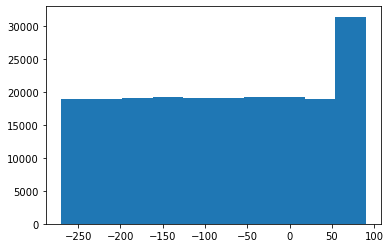

In [72]:
test=get_rel_theta(shapes)

import matplotlib.pyplot as plt
plt.hist(test)

In [40]:
# Drop clusters with no center
def drop_poor_centers():
    center_id=clusters[('Alt', 'Alt1', 'ID_CENT')]
    p=shapes.loc[center_id][('All','P')].to_numpy()
    missing_mem_match_id=clusters[np.isnan(p)].index
    clusters.drop(missing_mem_match_id,inplace=True)
#     np.save("/home/cz136/project/sa/data/missing_centers.npy",center_id[np.isnan(p)].to_numpy())
    print("The number of clusters with no center shape data {}".format(np.sum(np.isnan(p))))
drop_poor_centers()

# Drop members with no cluster
def drop_poor_members():
    valid_clusters_id=clusters.index.to_numpy()
    shapes_match_id=shapes[('All','MEM_MATCH_ID')].to_numpy()
    print("Number of galaxies before masking: {}".format(len(shapes_match_id)))
    valid_members=np.isin(shapes_match_id,valid_clusters_id)
    return(valid_members)
    
valid_members_id=drop_poor_members()
print("Number of galaxies after masking: {}".format(len(shapes)))
shapes=shapes[valid_members_id]

drop_poor_centers()
valid_members_id=drop_poor_members()
print("Number of galaxies after masking: {}".format(len(shapes)))
shapes=shapes[valid_members_id]

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


The number of clusters with no center shape data 4483
Number of galaxies before masking: 282735
Number of galaxies after masking: 282735
The number of clusters with no center shape data 1
Number of galaxies before masking: 203080
Number of galaxies after masking: 203080


In [41]:
shapes[('All','Theta_cen')]=shapes.apply(lambda x:get_rel_theta(x),axis=1)

In [42]:
shapes[('All','Theta_cen')]=shapes.apply(lambda x:360-x[('All','Theta_cen')] if x[('All','Theta_cen')]>=180 else x[('All','Theta_cen')],axis=1)
shapes[('All','Theta_cen')]=shapes.apply(lambda x:360+x[('All','Theta_cen')] if x[('All','Theta_cen')]<=-180 else x[('All','Theta_cen')],axis=1)
shapes[('All','Theta_sat')]=shapes.apply(lambda x:-(180-x[('All','Theta_cen')]) if x[('All','Theta_cen')]>=0 else (180+x[('All','Theta_cen')]),axis=1)

In [43]:
H0=100 #km s-1 Mpc-1
Om0=0.3
Ode0=0.7
lcdm=astropy.cosmology.FlatLambdaCDM(H0, Om0)

In [44]:
shapes[('All','angR')]=shapes.apply(lambda x:np.float(lcdm.angular_diameter_distance(x[('All','Z')])/u.Mpc),axis=1)
random[('All','angR')]=random.apply(lambda x:np.float(lcdm.angular_diameter_distance(x[('All','Z')])/u.Mpc),axis=1)

# Add $\phi$

In [45]:
def get_pa_for_member(obj):
    e1=obj['All']['e1']
    e2=obj['All']['e2']
    
    α =0.5*np.arctan2(-e2,-e1)*180/np.pi
    return(α)

In [46]:
error_list_phi=[]
error_list_e=[]

def get_phi_for_member(member):
    
    """Input: cluster series
        Output: an array of position angle weighted by PP
        Record KeyError in an array (usually caused by uncomplete shape catalog).
    """
    
    try:
        cluster_id=member[('All','MEM_MATCH_ID')]
        cluster=clusters.loc[cluster_id]
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]
        
        pa=get_pa_for_member(member)
        theta= get_theta_for_obj(member,center)
        phi=(pa-theta)
    #     print(center.index)
        return(phi)    
    except KeyError as e:
        error_list_phi.append(e)
        print(e)
        return(np.nan)

In [47]:
shapes[('All','phi')]=shapes.apply(lambda x:get_phi_for_member(x),axis=1)

In [48]:
def process_phi(phi_1d):

    phi_1d=np.where(phi_1d<=0,-phi_1d,phi_1d)
    phi_1d=np.where(phi_1d>=180,phi_1d-180,phi_1d)
    phi_1d=np.where(phi_1d>=90,180-phi_1d,phi_1d)

    
    return(phi_1d)

In [49]:
shapes[('All','phi')]=process_phi(shapes[('All','phi')])

# Add e

In [50]:
def get_e(sat):
    cluster_id=sat[('All','MEM_MATCH_ID')]
    cluster=clusters.loc[cluster_id]
    center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
    cen = shapes.loc[center_id]
    
    e=np.sqrt(sat[('All','e1')]**2+sat[('All','e2')]**2)
    delta=get_theta_for_obj(cen,sat)
    alpha=get_pa_for_member(sat)
    ep,ex=(e*np.cos(2*(delta-alpha)),e*np.sin(2*(delta-alpha)))
    return(ep,ex)

In [51]:
shapes[('All','ep')]=shapes.apply(lambda x:get_e(x)[0],axis=1)
shapes[('All','ex')]=shapes.apply(lambda x:get_e(x)[1],axis=1)

# Calculate cluster elipticity

In [52]:
display(Math(r"$M_{\mathrm{xx}} \equiv\left\langle\frac{x^{2}}{r^{2}}\right\rangle=\frac{\sum_{i} p_{\mathrm{mem}, i} \frac{x_{i}^{2}}{r_{i}^{2}}}{\sum_{i} p_{\mathrm{mem}, i}}$"))

<IPython.core.display.Math object>

In [53]:
def get_Q_U(cluster):
    
    mem_match_id=cluster.name
    members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]
    
    members=members[members[('All','PP')]>=0.2]
    
    def get_M_for_cluster():
        p = members[('All','PP')]
        r = members[('All','R')]
        pa = members[('All','Theta_cen')]
        x = r * np.cos(pa)
        y = r * np.sin(pa)
        
        def mom_2(p,x,y,r):
            return(np.sum(p*x*y/r**2)/np.sum(p))
        
        Mxx=mom_2(p,x,x,r)
        Mxy=mom_2(p,x,y,r)
        Myy=mom_2(p,y,y,r)
        return(Mxx,Mxy,Myy)

    Mxx,Mxy,Myy=get_M_for_cluster()
    Q,U=Mxx-Myy,2*Mxy
    
    return (Q,U)


def get_pa_from_Q_U(Q,U):
    α =0.5*np.arctan2(U,Q)*180/np.pi
    return(α)

In [54]:
clusters[('All','All','Q')]=clusters.apply(lambda x:get_Q_U(x)[0],axis=1)
clusters[('All','All','U')]=clusters.apply(lambda x:get_Q_U(x)[1],axis=1)
clusters[('All','All','Beta')]=clusters.apply(lambda x:get_pa_from_Q_U(x[('All','All','Q')],x[('All','All','U')]),axis=1)
clusters[('All','All','Ce')]=clusters.apply(lambda x:np.sqrt(x[('All','All','U')]**2+x[('All','All','U')]**2),axis=1)

In [55]:
def get_normLR(shape):
    cluster_id=shape[('All','MEM_MATCH_ID')]
    LR = clusters.loc[cluster_id][('All','All','R_LAMBDA')]
    angR=shape[('All','angR')]
    normR=angR/LR
    return(normR)

In [56]:
shapes[('All','normLR')]=shapes.apply(lambda x:get_normLR(x),axis=1)

In [57]:
def add_r_lambda(shape):
    cluster_id=shape[('All','MEM_MATCH_ID')]
    LR = clusters.loc[cluster_id][('All','All','R_LAMBDA')]
    return(LR)

In [58]:
shapes[('All','R_LAMBDA')]=shapes.apply(lambda x:add_r_lambda(x),axis=1)

# Save

In [59]:
clusters.to_pickle('/home/cz136/project/sa/data/{}/{}/clusters.pkl'.format(shape_cat,vol))

In [60]:
shapes.to_pickle('/home/cz136/project/sa/data/{}/{}/shapes.pkl'.format(shape_cat,vol))

In [61]:
random.to_pickle('/home/cz136/project/sa/data/{}/{}/random.pkl'.format(shape_cat,vol))

## z masking

In [62]:
def drop_shapes_wo_cluster(clusters,shapes):
    valid_clusters_id=clusters.index.to_numpy()
    shapes_match_id=shapes[('All','MEM_MATCH_ID')].to_numpy()
    print("Number of galaxies before masking: {}".format(len(shapes_match_id)))
    valid_members=np.isin(shapes_match_id,valid_clusters_id)
    shapes=shapes[valid_members]
    return(shapes)

In [63]:
high_z=clusters[clusters['All','All','Z_LAMBDA']>=0.35]
low_z=clusters[(clusters['All','All','Z_LAMBDA']<=0.35) & (clusters['All','All','Z_LAMBDA']>=0.1)]

In [64]:
high_z_shapes=drop_shapes_wo_cluster(high_z,shapes)
low_z_shapes=drop_shapes_wo_cluster(low_z,shapes)

Number of galaxies before masking: 203070
Number of galaxies before masking: 203070


In [65]:
high_z.to_pickle('/home/cz136/project/sa/data/{}/{}/clusters_high_z.pkl'.format(shape_cat,vol))
low_z.to_pickle('/home/cz136/project/sa/data/{}/{}/clusters_low_z.pkl'.format(shape_cat,vol))
high_z_shapes.to_pickle('/home/cz136/project/sa/data/{}/{}/shapes_high_z.pkl'.format(shape_cat,vol))
low_z_shapes.to_pickle('/home/cz136/project/sa/data/{}/{}/shapes_low_z.pkl'.format(shape_cat,vol))